In [67]:
import numpy as np
from scipy.stats import norm, binom, poisson
from scipy import stats
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py

In [68]:
NUM_EXPERIMENTS = 10000
SAMPLE_SIZE = np.arange(10,110,10)
# SAMPLE_SIZE = np.arange(10,30,10)

In [69]:
# Legendre polynomial
# def Legendre_poly(n, x):
#     if(n == 0):
#         return 1 # P0 = 1
#     elif(n == 1):
#         return x # P1 = x
#     else:
#         return (((2 * n)-1)*x * Legendre_poly(n-1, x)-(n-1)*Legendre_poly(n-2, x))/float(n)

polynomials = [
    np.poly1d([1]),
    np.poly1d([3.464102, -1.732051]),
    np.poly1d([13.41641, -13.41641, 2.236068]),
    np.poly1d([52.91503, -79.37254, 31.74902, -2.645751]),
    np.poly1d([210, -420, 270, -60, 3]),
    np.poly1d([835.7894, -2089.474, 1857.31, -696.4912, 99.49874, -3.316625]),
    np.poly1d([3331.529, -9994.588, 11357.49, -6057.326, 1514.332, -151.4332,  3.605551]),
    np.poly1d([13292.08, -46522.28, 64415.46, -44732.96, 16266.53, -2927.975, 216.8871, -3.872983]),
    np.poly1d([53064.37, -212257.5, 346687.2, -297160.5, 142865.6, -38097.5, 5195.113, -296.8636, 4.123106]),
]



### Statistics

In [74]:
def get_P_statistic(k):
    As = np.linspace(0,1,k+1)
    
    def P(ns):
        res = 0
        n = len(ns)
        for j in range(k):
            Nj = 0
            for x in ns:
                if x > As[j] and x <= As[j+1]:
                    Nj+=1
            pj = (As[j+1]-As[j])
            res += (Nj-n*pj)**2 / (n*pj)
        return res
    return P

def get_N_statistic(k):
    def K(ns):
        res = 0
        n = len(ns)
        for j in range(1,k+1):
            inner_sum = 0
            for x in ns:
                inner_sum += polynomials[j](x)
            res += (inner_sum / np.sqrt(n)) ** 2
        return res
    return K



def KS(X: np.ndarray) -> float:
    N = len(X)
    return np.sqrt(N) * stats.kstest(rvs=X, cdf="uniform").statistic



In [75]:
statistics = {'P4': get_P_statistic(4), 'P8': get_P_statistic(8),
              'N1': get_N_statistic(1), 'N4': get_N_statistic(4), 
              'N8': get_N_statistic(8), 'KS': KS}

### Ex. 1

In [76]:
results = np.zeros((6, len(SAMPLE_SIZE), NUM_EXPERIMENTS))

In [77]:
for k, sample_size in enumerate(SAMPLE_SIZE):
    for j in tqdm(range(NUM_EXPERIMENTS)):
        ns = np.random.uniform(0,1,sample_size)
        for i, stat in enumerate(statistics.values()):
            results[i][k][j] = stat(ns)

100%|█████████████████████████████████████| 10000/10000 [02:18<00:00, 72.25it/s]


In [187]:
np.set_printoptions(precision=2)
quantiles = np.quantile(results, 0.95, axis=2)
print(quantiles)

[[ 8.4  10.8  11.87 13.4  14.96 16.4  17.89 19.1  19.69 20.96]
 [15.6  16.   18.   19.2  20.72 22.15 23.26 24.8  25.38 26.88]
 [ 5.9   7.88  9.5  10.87 12.54 13.96 15.44 16.79 17.57 19.02]
 [11.04 12.45 14.05 15.46 16.78 18.42 19.78 21.11 21.7  23.05]
 [17.18 18.75 19.69 21.17 22.22 23.99 24.93 26.6  27.28 28.57]
 [ 1.49  1.66  1.77  1.88  1.99  2.07  2.15  2.22  2.28  2.34]]


In [188]:
true_values = np.array([[7.81, 14.07, 3.84, 9.49, 15.51, 1.36]]).reshape(6,1)

In [189]:
(quantiles-true_values).var(axis=1)

array([15.71, 14.07, 17.18, 15.12, 13.39,  0.07])

### Ex. 3

In [256]:
def get_density(p=0.4, j=1):
    def f(x):
        return 1 + p*np.cos(j * np.pi * x)
    return f


def get_sample(n, f, p=0.4, j=1):
    scaling_factor = 1 + p
    sample = np.array([])
    
    while sample.size < n:
        u = np.random.uniform(low=0, high=1)
        v = np.random.uniform(low=0, high=scaling_factor)
        if v < f(u):
            sample = np.append(sample, u)
    return sample

In [263]:
results = np.zeros((6, len(SAMPLE_SIZE), NUM_EXPERIMENTS))
f = get_density()


for k, sample_size in enumerate(SAMPLE_SIZE):
    for j in tqdm(range(NUM_EXPERIMENTS)):
        ns = get_sample(sample_size, f)
        for i, stat in enumerate(statistics.values()):
            results[i][k][j] = stat(ns)

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.01it/s]


In [264]:
np.set_printoptions(precision=2)
quantiles = np.quantile(results, 0.95, axis=2)
print(quantiles)

[[ 8.4  10.   13.21 13.8  15.12 17.33 17.55 18.9  19.96 22.16]
 [15.6  16.   18.53 19.2  21.36 22.41 22.81 23.61 25.56 26.57]
 [ 5.64  7.83  9.96 11.46 12.95 15.12 15.67 16.43 17.28 19.5 ]
 [10.77 12.66 14.83 16.01 17.69 20.14 19.62 20.52 20.99 23.42]
 [16.72 18.85 20.91 21.08 23.23 24.9  24.64 25.64 26.77 29.17]
 [ 1.49  1.65  1.81  1.9   2.01  2.11  2.16  2.21  2.3   2.38]]


In [265]:
(results[0] > true_values[0]).sum(axis=1)

array([ 65, 110, 240, 265, 345, 419, 453, 535, 586, 635])

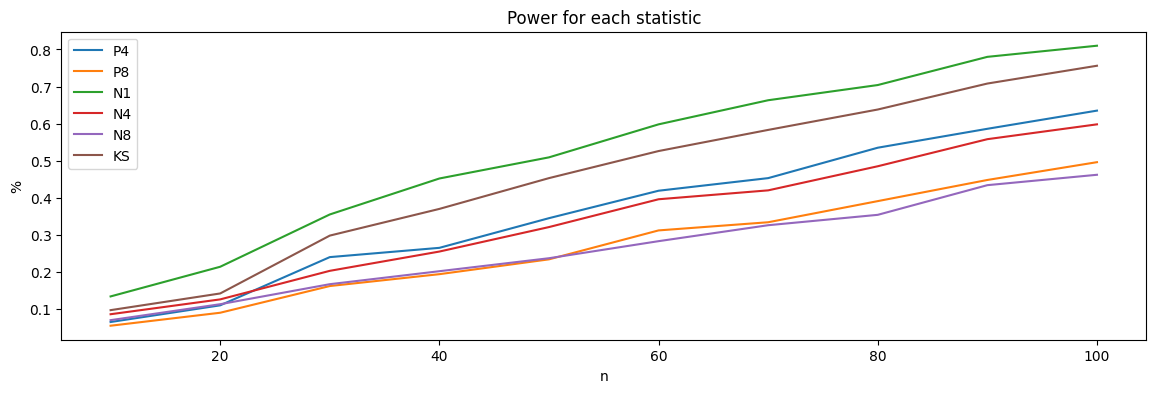

In [266]:
plt.figure(figsize=(14,4))

for i in range(6):
    power = (results[i] > true_values[i]).sum(axis=1) / NUM_EXPERIMENTS
    plt.plot(SAMPLE_SIZE, power, label=list(statistics.keys())[i])
plt.title('Power for each statistic')
plt.xlabel("n")
plt.ylabel("%")
plt.legend()

In [221]:
NUM_EXPERIMENTS = 1000
def solve(jj, pp):
    results = np.zeros((6, len(SAMPLE_SIZE), NUM_EXPERIMENTS))
    f = get_density(pp, jj)


    for k, sample_size in enumerate(SAMPLE_SIZE):
        for j in tqdm(range(NUM_EXPERIMENTS)):
            ns = get_sample(sample_size, f, pp, jj)
            for i, stat in enumerate(statistics.values()):
                results[i][k][j] = stat(ns)

    plt.figure(figsize=(14,4))

    for i in range(6):
        power = (results[i] > true_values[i]).sum(axis=1) / NUM_EXPERIMENTS
        print(power)
        plt.plot(SAMPLE_SIZE, power, label=list(statistics.keys())[i])
    plt.title(f"Power of the tests C_{jj}(u, {pp})")
    plt.xlabel("n")
    plt.ylabel("%")
    plt.legend()

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.77it/s]


[0.09 0.15 0.27 0.32 0.48 0.56 0.59 0.68 0.72 0.77]
[0.06 0.15 0.19 0.25 0.38 0.49 0.51 0.6  0.67 0.72]
[0.08 0.09 0.08 0.07 0.1  0.1  0.09 0.08 0.09 0.1 ]
[0.15 0.24 0.33 0.41 0.56 0.65 0.68 0.77 0.82 0.85]
[0.14 0.22 0.28 0.33 0.49 0.53 0.59 0.65 0.71 0.76]
[0.08 0.13 0.15 0.19 0.28 0.35 0.35 0.41 0.46 0.49]


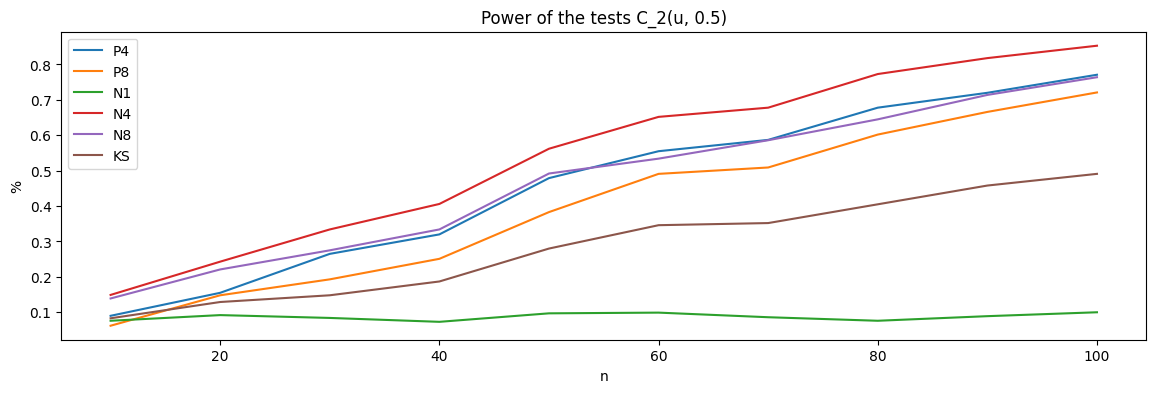

In [259]:
solve(2,0.5)
# f = get_density(0.7, 5)
# ns = get_sample(10000, f, 0.7, 5)

100%|█████████████████████████████████████| 10000/10000 [02:28<00:00, 67.23it/s]


[0.09 0.2  0.33 0.42 0.52 0.61 0.69 0.75 0.81 0.85]
[0.06 0.15 0.23 0.29 0.37 0.47 0.54 0.61 0.68 0.74]
[0.18 0.34 0.49 0.62 0.71 0.79 0.85 0.9  0.93 0.95]
[0.1  0.19 0.29 0.39 0.48 0.57 0.65 0.72 0.79 0.83]
[0.09 0.14 0.21 0.28 0.35 0.44 0.51 0.58 0.66 0.71]
[0.13 0.27 0.41 0.54 0.63 0.73 0.79 0.85 0.89 0.92]


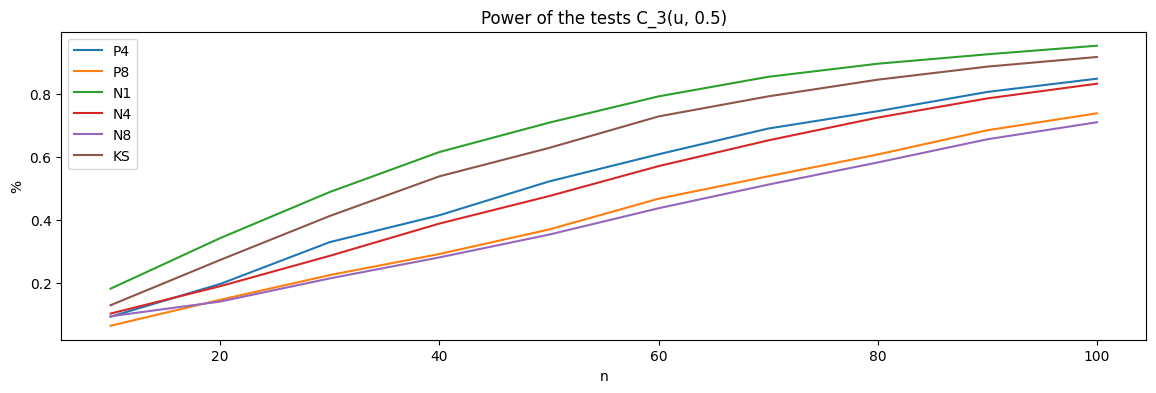

In [219]:
solve(3,0.5)

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.74it/s]


[0.04 0.05 0.05 0.04 0.04 0.06 0.05 0.06 0.06 0.06]
[0.07 0.17 0.26 0.37 0.43 0.58 0.62 0.74 0.77 0.83]
[0.06 0.06 0.06 0.06 0.05 0.06 0.07 0.06 0.06 0.06]
[0.16 0.21 0.33 0.42 0.5  0.6  0.65 0.73 0.74 0.82]
[0.17 0.25 0.39 0.49 0.58 0.69 0.76 0.83 0.87 0.91]
[0.04 0.07 0.07 0.08 0.1  0.11 0.14 0.17 0.19 0.2 ]


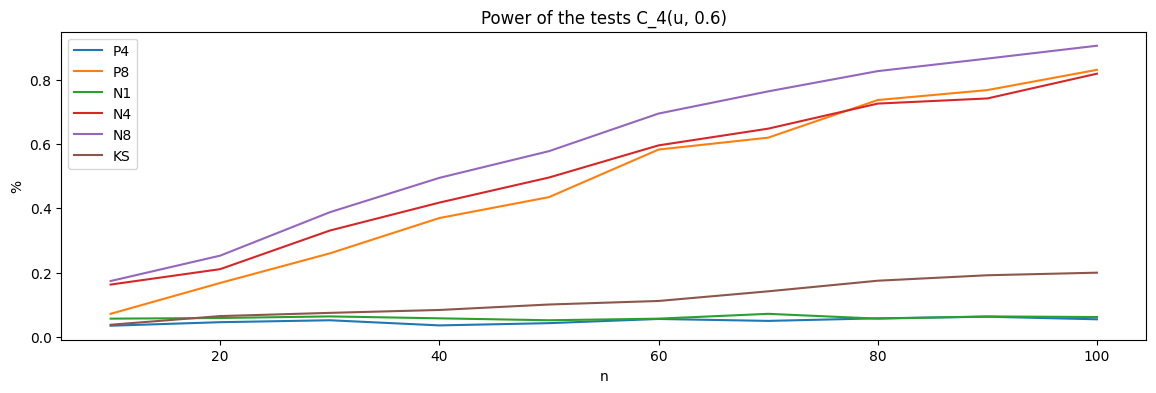

In [260]:
solve(4,0.6)

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.94it/s]


[0.07 0.09 0.17 0.17 0.24 0.3  0.35 0.39 0.44 0.46]
[0.08 0.19 0.3  0.41 0.52 0.65 0.76 0.8  0.87 0.89]
[0.04 0.05 0.06 0.06 0.04 0.05 0.05 0.06 0.06 0.06]
[0.06 0.08 0.11 0.11 0.12 0.16 0.18 0.19 0.21 0.22]
[0.11 0.22 0.38 0.54 0.66 0.77 0.86 0.91 0.93 0.96]
[0.03 0.04 0.07 0.1  0.08 0.13 0.14 0.15 0.17 0.17]


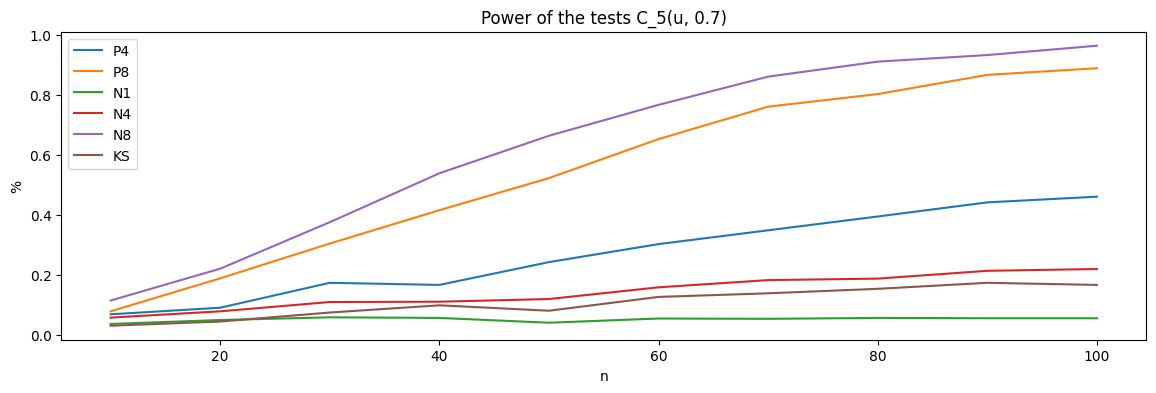

In [261]:
solve(5,0.7)

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 55.51it/s]


[0.05 0.07 0.1  0.1  0.12 0.15 0.18 0.16 0.15 0.21]
[0.07 0.17 0.25 0.36 0.46 0.57 0.67 0.71 0.77 0.82]
[0.06 0.05 0.06 0.06 0.07 0.06 0.04 0.05 0.06 0.05]
[0.11 0.14 0.12 0.2  0.23 0.28 0.29 0.33 0.35 0.41]
[0.18 0.3  0.44 0.61 0.73 0.82 0.86 0.9  0.95 0.98]
[0.03 0.04 0.06 0.07 0.1  0.1  0.09 0.1  0.12 0.13]


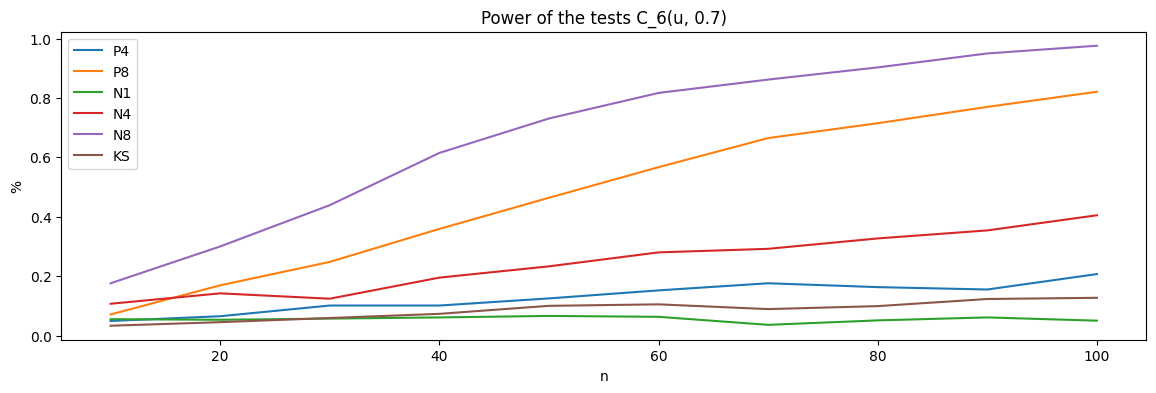

In [262]:
solve(6,0.7)